In [51]:
import torch
import timm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, Normalizer
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, confusion_matrix ,roc_curve,roc_auc_score
from tqdm import tqdm
from PIL import Image
import seaborn as sns

In [52]:
train_path = 'input/train.csv'
test_path = 'input/test.csv'
MAX_EPOCH = 100
BATCH_SIZE = 128
weight_decay = 1e-3
LR=0.0001
img_size = 128
sd_features = ['X4_sd', 'X11_sd','X18_sd', 'X26_sd', 'X50_sd', 'X3112_sd']
label_features = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']


In [53]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df['id'] = train_df['id'].map(lambda x: 'train_images/' + str(x)+ ".jpeg")
test_df['id'] = test_df['id'].map(lambda x: 'test_images/' + str(x)+ ".jpeg")
FEATURE_COLS = test_df.columns[1:].tolist()

**Test sd?**

### Delete abnormal values

In [54]:
train_df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,train_images/192027691.jpeg,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,train_images/195542235.jpeg,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
2,train_images/196639184.jpeg,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
3,train_images/195728812.jpeg,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,1.083629,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
4,train_images/195251545.jpeg,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.657585,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55484,train_images/190558785.jpeg,19.472172,244.795914,39.127552,67.074493,472.710358,27.758673,118,140,131,...,0.233690,1.783193,1.608341,969.547831,NaN,NaN,NaN,NaN,NaN,NaN
55485,train_images/194523231.jpeg,13.724150,1450.000000,162.260208,43.139324,652.716858,26.694387,125,144,135,...,1.017099,12.713048,2.418300,1630.015480,0.005474,0.128133,0.117010,3.164520,0.082212,136.503697
55486,train_images/195888987.jpeg,14.741204,581.866638,109.231110,89.272148,507.273010,26.874668,118,155,136,...,2.717395,10.206478,2.722599,602.229880,0.019727,0.215040,0.156309,0.919139,0.079395,26.159626
55487,train_images/135487319.jpeg,16.094763,1180.838135,80.176193,22.909716,342.184021,17.346189,109,130,117,...,4.429659,9.372170,3.251739,244.387170,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
quntilelist=np.array(train_df[label_features].quantile([0,0.99]))
IQR=quntilelist[1]-quntilelist[0]
low_bound=quntilelist[0]-1.5*IQR
upper_bound=quntilelist[1]+1.5*IQR
for i in range(len(label_features)):
    train_df = train_df[(train_df[label_features[i]] < upper_bound[i]) & (train_df[label_features[i]] > low_bound[i]) | train_df[label_features[i]].isna()]

In [56]:
quntilelist=np.array(train_df[sd_features].quantile([0,0.95]))
IQR=quntilelist[1]-quntilelist[0]
low_bound=quntilelist[0]-1.5*IQR
upper_bound=quntilelist[1]+1.5*IQR
for i in range(len(sd_features)):
    train_df = train_df[(train_df[sd_features[i]] < upper_bound[i]) & (train_df[sd_features[i]] > low_bound[i]) | train_df[sd_features[i]].isna()]

In [57]:
train_df

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X18_mean,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,train_images/192027691.jpeg,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,0.117484,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,train_images/195542235.jpeg,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.389315,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
2,train_images/196639184.jpeg,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,8.552908,0.395241,2.343153,1130.096731,NaN,NaN,NaN,NaN,NaN,NaN
3,train_images/195728812.jpeg,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,1.083629,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
4,train_images/195251545.jpeg,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,0.657585,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55484,train_images/190558785.jpeg,19.472172,244.795914,39.127552,67.074493,472.710358,27.758673,118,140,131,...,0.233690,1.783193,1.608341,969.547831,NaN,NaN,NaN,NaN,NaN,NaN
55485,train_images/194523231.jpeg,13.724150,1450.000000,162.260208,43.139324,652.716858,26.694387,125,144,135,...,1.017099,12.713048,2.418300,1630.015480,0.005474,0.128133,0.117010,3.164520,0.082212,136.503697
55486,train_images/195888987.jpeg,14.741204,581.866638,109.231110,89.272148,507.273010,26.874668,118,155,136,...,2.717395,10.206478,2.722599,602.229880,0.019727,0.215040,0.156309,0.919139,0.079395,26.159626
55487,train_images/135487319.jpeg,16.094763,1180.838135,80.176193,22.909716,342.184021,17.346189,109,130,117,...,4.429659,9.372170,3.251739,244.387170,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
label_df = train_df[label_features+sd_features]
train_df = train_df.drop(columns = label_features+sd_features)
# label_df = np.log1p(label_df)

In [59]:
x_train,x_val,y_train,y_val = train_test_split(train_df, label_df, test_size=0.1)
x_train_images = np.array(x_train['id']) 
x_train = x_train.drop(columns = 'id')
x_val_images = np.array(x_val['id']) 
x_val = x_val.drop(columns = 'id')
y_train,y_val = np.array(y_train).astype(np.float32), np.array(y_val).astype(np.float32)

In [60]:
scaler = Normalizer()
train_features = scaler.fit_transform(x_train[FEATURE_COLS].values).astype(np.float32)
valid_features = scaler.transform(x_val[FEATURE_COLS].values).astype(np.float32)

# scaler_y = Normalizer()
# train_labels = y_train
# y_train = scaler_y.fit_transform(y_train).astype(np.float32)
# y_val = scaler_y.transform(y_val).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)
train_labels = y_train[:,:6]
train_labels_aux = y_train[:,6:]
val_labels = y_val[:,:6]
val_labels_aux = y_val[:,6:]

train_features[np.isnan(train_features)] = -1
valid_features[np.isnan(valid_features)] = -1
train_labels[np.isnan(train_labels)] = -1
train_labels_aux[np.isnan(train_labels_aux)] = -1
val_labels[np.isnan(val_labels)] = -1
val_labels_aux[np.isnan(val_labels_aux)] = -1

In [61]:
train_dataset = [(x_train_images[i], train_features[i],train_labels[i], train_labels_aux[i] ) for i in range(len(x_train_images))]
val_dataset = [(x_val_images[i], valid_features[i],val_labels[i],val_labels_aux[i]) for i in range(len(x_val_images))]
train_loader = DataLoader(dataset = train_dataset, batch_size=BATCH_SIZE , shuffle= True, num_workers = 2)
val_loader = DataLoader(dataset = val_dataset, batch_size=BATCH_SIZE , shuffle= False, num_workers = 2)

In [62]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super(MLP,self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(163, 128), nn.BatchNorm1d(128), nn.SELU(), nn.Dropout())
        self.linear2 = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.SELU(), nn.Dropout())
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class Combine_model(nn.Module):
    def __init__(self) -> None:
        super(Combine_model,self).__init__()
        self.model1 = timm.create_model('convnext_tiny',pretrained=True)
        self.model1.head.fc=nn.Sequential(
            nn.Linear(self.model1.head.fc.in_features, 128), 
            nn.BatchNorm1d(128), 
            nn.Tanh(),
            nn.Dropout()
        )
        self.model2 = MLP()
        self.fc = nn.Linear(128+64, 6)
        self.out_fc1 = nn.Sequential(
            nn.Linear(128+64,24), 
            nn.BatchNorm1d(24), 
            nn.ReLU(),
        )
        self.out_fc2 = nn.Linear(24,6)
        self.out_fc3 = nn.Linear(24,6)
    def forward(self,x,y):
        x = self.model1(x)
        y = self.model2(y)
        x = torch.cat([x,y], dim = 1)
        x = self.out_fc1(x)
        return self.out_fc2(x), self.out_fc3(x)


In [63]:
train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=(0.45, 0.55), hue=0.1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((-10,10)),
        transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0), ratio=(0.8, 1.25)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
valid_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])  


In [64]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [65]:
class R2Loss(nn.Module):
    def __init__(self, use_mask=False):
        super(R2Loss, self).__init__()
        self.use_mask = use_mask

    def forward(self,y_pred , y_true):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = torch.where(mask, y_true, torch.zeros_like(y_true))
            y_pred = torch.where(mask, y_pred, torch.zeros_like(y_pred))
        SS_res = torch.sum((y_true - y_pred) ** 2,axis=0)
        SS_tot = torch.sum((y_true - torch.mean(y_true, 1, True)) ** 2,axis=0)
        r2_loss = SS_res / (SS_tot + 1e-6)
        return torch.mean(r2_loss)
    

class MSELoss(nn.Module):
    def __init__(self, use_mask=False):
        super(MSELoss, self).__init__()
        self.use_mask = use_mask

    def forward(self, y_pred, y_true):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = torch.where(mask, y_true, torch.zeros_like(y_true))
            y_pred = torch.where(mask, y_pred, torch.zeros_like(y_pred))
        mse_loss = torch.mean((y_true - y_pred) ** 2)
        return mse_loss

In [66]:
def train_epoch(train_loader,model, criterion1, criterion2, optimizer, scheduler, device, img_size):
    model.train()
    total_loss = 0
    for i, data in tqdm(enumerate(train_loader)):
        # Unpack data
        img_path, inputs, labels, labels_aux = data

        # Prepare image paths
        # # Prepare inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels_aux = labels_aux.to(device)

        # Load and transform images
        batch_size = len(img_path)
        images = torch.zeros(batch_size, 3, img_size, img_size, dtype=torch.float32)
        for i in range(batch_size):
            # image = cv2.imread(img_path[i]).numpy()
            image = Image.open(img_path[i]).convert("RGB")
            # images[i] = image
            images[i] = train_transform(image)  # Assuming train_transform is defined elsewhere
        # Forward pass
        images = images.to(device)
        output1,output2 = model(images, inputs)
        # Backward and optimize
        optimizer.zero_grad()
        loss1 = criterion1[0](output1, labels)       
        loss2 = criterion2[0](output2,labels_aux) 
        loss = loss1 + 0.1*loss2
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [67]:
def evaluate_epoch(test_loader,model,criterion1,criterion2,device, img_size):
    model.eval()

    total_loss = 0
    total_r2_loss = 0
    output = []
    total_label = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader)):
            # Unpack data
            img_path, inputs, labels, labels_aux = data
            # img_path = ['/Users/zhangyumeng/Desktop/23Winter/273P/project/planttraits2024/'+i for i in img_path]
            # Prepare image paths
            # # Prepare inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_aux = labels_aux.to(device)

            batch_size = len(img_path)
            images = torch.zeros(batch_size, 3, img_size, img_size, dtype=torch.float32)

            for j in range(batch_size):
                image = Image.open(img_path[j]).convert("RGB")
                images[j] = valid_transform(image)   # Assuming train_transform is defined elsewhere
            # Forward pass
            images = images.to(device)
            output1,output2 = model(images, inputs)
            output.append(output1)
            total_label.append(labels)
            loss1 = criterion1[0](output1, labels) + 0.2*criterion2[0](output2,labels_aux)     
            loss2 = criterion1[0](output1, labels)
            total_r2_loss += loss2.item()
            total_loss += loss1.item()

        avg_loss = total_loss/len(test_loader)
        avg_r2_loss = total_r2_loss/len(test_loader)
        total_r2 = criterion1[0](torch.cat(output, dim = 0), torch.cat(total_label, dim = 0))
    return avg_loss, avg_r2_loss, total_r2
    

In [68]:
losses = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Combine_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=weight_decay, lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCH, eta_min=0, last_epoch=-1)
criterion1 = [R2Loss(use_mask=False), MSELoss(use_mask=False)]
criterion2 = [R2Loss(use_mask=True), MSELoss(use_mask=True)]
best_r2 = -5
for epoch in range(MAX_EPOCH):
    print('epoch',epoch)
    train_loss = train_epoch(train_loader,model,criterion1,criterion2,optimizer,scheduler,device,img_size)
    test_loss, test_r2_loss, total_R2 = evaluate_epoch(val_loader,model, criterion1,criterion2, device, img_size)
    best_r2 = max(best_r2, 1 - total_R2)
    print("Train_loss is: {}, test loss is: {}, test R2 loss is: {}, test R2 is: {}, current best result: {}".format(train_loss, test_loss, test_r2_loss, 1 - total_R2, best_r2))
    losses.append([train_loss, test_r2_loss, test_r2_loss, total_R2])
    

epoch 0


369it [06:25,  1.05s/it]
41it [00:18,  2.27it/s]


Train_loss is: 0.27790666805696357, test loss is: 0.29712587885740327, test R2 loss is: 0.24871244917555554, test R2 is: 0.752230167388916, current best result: 0.752230167388916
epoch 1


369it [06:23,  1.04s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.2780462838608398, test loss is: 0.29704564955176377, test R2 loss is: 0.2486501815842419, test R2 is: 0.7522822022438049, current best result: 0.7522822022438049
epoch 2


369it [06:18,  1.03s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.2785352541179192, test loss is: 0.29706280623994225, test R2 loss is: 0.24866486431621923, test R2 is: 0.7522704601287842, current best result: 0.7522822022438049
epoch 3


369it [06:12,  1.01s/it]
41it [00:17,  2.41it/s]


Train_loss is: 0.2780764520491365, test loss is: 0.29704867485092906, test R2 loss is: 0.24865226011450697, test R2 is: 0.7522816061973572, current best result: 0.7522822022438049
epoch 4


369it [06:12,  1.01s/it]
41it [00:16,  2.43it/s]


Train_loss is: 0.27804523342993204, test loss is: 0.2970523063729449, test R2 loss is: 0.24865601884155739, test R2 is: 0.752278745174408, current best result: 0.7522822022438049
epoch 5


369it [06:10,  1.00s/it]
41it [00:17,  2.37it/s]


Train_loss is: 0.27774814078155247, test loss is: 0.2970409509612293, test R2 loss is: 0.24864886264975478, test R2 is: 0.7522845268249512, current best result: 0.7522845268249512
epoch 6


369it [06:12,  1.01s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.2769782245159149, test loss is: 0.29701298402576914, test R2 loss is: 0.24862985167561508, test R2 is: 0.7523009181022644, current best result: 0.7523009181022644
epoch 7


369it [06:13,  1.01s/it]
41it [00:16,  2.43it/s]


Train_loss is: 0.2782779292362492, test loss is: 0.29703494761048294, test R2 loss is: 0.24865170513711324, test R2 is: 0.7522822618484497, current best result: 0.7523009181022644
epoch 8


369it [06:09,  1.00s/it]
41it [00:17,  2.40it/s]


Train_loss is: 0.27734265894424626, test loss is: 0.2969898145373275, test R2 loss is: 0.24861986317285678, test R2 is: 0.7523092031478882, current best result: 0.7523092031478882
epoch 9


369it [06:12,  1.01s/it]
41it [00:17,  2.41it/s]


Train_loss is: 0.27781105534171024, test loss is: 0.29699746937286564, test R2 loss is: 0.24862729449097704, test R2 is: 0.7523027658462524, current best result: 0.7523092031478882
epoch 10


369it [06:12,  1.01s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.2781093292604617, test loss is: 0.2969829585494065, test R2 loss is: 0.24861999255854908, test R2 is: 0.7523087859153748, current best result: 0.7523092031478882
epoch 11


369it [06:13,  1.01s/it]
41it [00:16,  2.45it/s]


Train_loss is: 0.2781658180683932, test loss is: 0.2970126423893905, test R2 loss is: 0.24864070081129308, test R2 is: 0.7522910833358765, current best result: 0.7523092031478882
epoch 12


369it [06:12,  1.01s/it]
41it [00:17,  2.38it/s]


Train_loss is: 0.27778997330807736, test loss is: 0.2969241062315499, test R2 loss is: 0.2485849784641731, test R2 is: 0.7523378729820251, current best result: 0.7523378729820251
epoch 13


369it [06:10,  1.00s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.2771230789865582, test loss is: 0.2969782112575159, test R2 loss is: 0.24861976358948684, test R2 is: 0.7523088455200195, current best result: 0.7523378729820251
epoch 14


369it [06:12,  1.01s/it]
41it [00:16,  2.41it/s]


Train_loss is: 0.2780720702193294, test loss is: 0.29698228472616617, test R2 loss is: 0.24862239527993085, test R2 is: 0.7523066401481628, current best result: 0.7523378729820251
epoch 15


369it [06:09,  1.00s/it]
41it [00:16,  2.41it/s]


Train_loss is: 0.2774400563259435, test loss is: 0.29698156438222745, test R2 loss is: 0.24862145832399044, test R2 is: 0.7523074150085449, current best result: 0.7523378729820251
epoch 16


369it [06:10,  1.00s/it]
41it [00:16,  2.43it/s]


Train_loss is: 0.27768644375529716, test loss is: 0.29698350734826995, test R2 loss is: 0.2486235383080273, test R2 is: 0.7523054480552673, current best result: 0.7523378729820251
epoch 17


369it [06:10,  1.00s/it]
41it [00:16,  2.43it/s]


Train_loss is: 0.2776092487945143, test loss is: 0.2969825863838196, test R2 loss is: 0.2486234739786241, test R2 is: 0.7523054480552673, current best result: 0.7523378729820251
epoch 18


369it [06:11,  1.01s/it]
41it [00:16,  2.44it/s]


Train_loss is: 0.2774751826030452, test loss is: 0.2969903676975064, test R2 loss is: 0.2486269103317726, test R2 is: 0.7523026466369629, current best result: 0.7523378729820251
epoch 19


369it [06:11,  1.01s/it]
41it [00:17,  2.41it/s]


Train_loss is: 0.2774171228331279, test loss is: 0.2970055319914004, test R2 loss is: 0.24863684286431567, test R2 is: 0.7522942423820496, current best result: 0.7523378729820251
epoch 20


369it [06:12,  1.01s/it]
41it [00:17,  2.40it/s]


Train_loss is: 0.2778035428142806, test loss is: 0.29699313567905894, test R2 loss is: 0.248629274891644, test R2 is: 0.7523003816604614, current best result: 0.7523378729820251
epoch 21


369it [06:08,  1.00it/s]
41it [00:17,  2.40it/s]


Train_loss is: 0.27785480232419685, test loss is: 0.2969986592851034, test R2 loss is: 0.24863209411865328, test R2 is: 0.7522979974746704, current best result: 0.7523378729820251
epoch 22


369it [06:09,  1.00s/it]
41it [00:16,  2.45it/s]


Train_loss is: 0.27738059326239073, test loss is: 0.29699267846782035, test R2 loss is: 0.24862818201867545, test R2 is: 0.7523012161254883, current best result: 0.7523378729820251
epoch 23


369it [06:09,  1.00s/it]
41it [00:16,  2.46it/s]


Train_loss is: 0.27763682733060224, test loss is: 0.296994760269072, test R2 loss is: 0.24862996434293141, test R2 is: 0.7522995471954346, current best result: 0.7523378729820251
epoch 24


369it [06:07,  1.00it/s]
41it [00:16,  2.44it/s]


Train_loss is: 0.2776639763578813, test loss is: 0.297018017710709, test R2 loss is: 0.24864355710948385, test R2 is: 0.7522881031036377, current best result: 0.7523378729820251
epoch 25


369it [06:10,  1.00s/it]
41it [00:16,  2.42it/s]


Train_loss is: 0.2782178404854565, test loss is: 0.2969758248910671, test R2 loss is: 0.2486186122022024, test R2 is: 0.7523088455200195, current best result: 0.7523378729820251
epoch 26


369it [06:07,  1.00it/s]
41it [00:16,  2.45it/s]


Train_loss is: 0.27767935645612596, test loss is: 0.2970122782195487, test R2 loss is: 0.24864004188921393, test R2 is: 0.7522909641265869, current best result: 0.7523378729820251
epoch 27


369it [06:09,  1.00s/it]
41it [00:16,  2.44it/s]


Train_loss is: 0.27797283551234214, test loss is: 0.2970160071442767, test R2 loss is: 0.2486424860430927, test R2 is: 0.7522889375686646, current best result: 0.7523378729820251
epoch 28


369it [06:09,  1.00s/it]
41it [00:16,  2.42it/s]


Train_loss is: 0.2776808227465405, test loss is: 0.29702506705028253, test R2 loss is: 0.2486480885162586, test R2 is: 0.7522841691970825, current best result: 0.7523378729820251
epoch 29


369it [06:09,  1.00s/it]
41it [00:16,  2.43it/s]


Train_loss is: 0.2783030189149748, test loss is: 0.297030681517066, test R2 loss is: 0.2486513507802312, test R2 is: 0.7522813677787781, current best result: 0.7523378729820251
epoch 30


369it [06:09,  1.00s/it]
41it [00:17,  2.38it/s]


Train_loss is: 0.27760306477223634, test loss is: 0.2970286382407677, test R2 loss is: 0.24865057155853365, test R2 is: 0.7522820234298706, current best result: 0.7523378729820251
epoch 31


369it [06:07,  1.01it/s]
41it [00:16,  2.43it/s]


Train_loss is: 0.2776974639110772, test loss is: 0.2970447838306427, test R2 loss is: 0.24866062148315152, test R2 is: 0.7522733211517334, current best result: 0.7523378729820251
epoch 32


369it [06:08,  1.00it/s]
41it [00:16,  2.41it/s]


Train_loss is: 0.27746065457661945, test loss is: 0.29702533454429814, test R2 loss is: 0.24864810886906413, test R2 is: 0.7522839307785034, current best result: 0.7523378729820251
epoch 33


369it [06:09,  1.00s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.27780608013070374, test loss is: 0.2970433104328993, test R2 loss is: 0.24865962455912335, test R2 is: 0.7522741556167603, current best result: 0.7523378729820251
epoch 34


369it [06:06,  1.01it/s]
41it [00:16,  2.43it/s]


Train_loss is: 0.27815776643391227, test loss is: 0.2970441056460869, test R2 loss is: 0.24866017626553047, test R2 is: 0.752273678779602, current best result: 0.7523378729820251
epoch 35


369it [06:08,  1.00it/s]
41it [00:17,  2.40it/s]


Train_loss is: 0.2777630079406387, test loss is: 0.2970473693638313, test R2 loss is: 0.2486619687661892, test R2 is: 0.7522721290588379, current best result: 0.7523378729820251
epoch 36


369it [06:10,  1.00s/it]
41it [00:16,  2.45it/s]


Train_loss is: 0.27832258264546794, test loss is: 0.29705116734272097, test R2 loss is: 0.24866478581254076, test R2 is: 0.7522697448730469, current best result: 0.7523378729820251
epoch 37


369it [06:09,  1.00s/it]
41it [00:17,  2.40it/s]


Train_loss is: 0.2777548140788143, test loss is: 0.29705230346540124, test R2 loss is: 0.24866563009052742, test R2 is: 0.75226891040802, current best result: 0.7523378729820251
epoch 38


369it [06:09,  1.00s/it]
41it [00:16,  2.45it/s]


Train_loss is: 0.2784689910366606, test loss is: 0.29705208321897, test R2 loss is: 0.24866528990792064, test R2 is: 0.7522692084312439, current best result: 0.7523378729820251
epoch 39


369it [06:09,  1.00s/it]
41it [00:16,  2.46it/s]


Train_loss is: 0.27766247097715774, test loss is: 0.29705597641991405, test R2 loss is: 0.24866760722020778, test R2 is: 0.7522672414779663, current best result: 0.7523378729820251
epoch 40


369it [06:10,  1.00s/it]
41it [00:16,  2.44it/s]


Train_loss is: 0.27782047925602776, test loss is: 0.29705908749161697, test R2 loss is: 0.24866977951875546, test R2 is: 0.7522653341293335, current best result: 0.7523378729820251
epoch 41


369it [06:09,  1.00s/it]
41it [00:16,  2.47it/s]


Train_loss is: 0.27727196371652246, test loss is: 0.2970617806039205, test R2 loss is: 0.24867123110992154, test R2 is: 0.7522640824317932, current best result: 0.7523378729820251
epoch 42


369it [06:09,  1.00s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.2778838999710755, test loss is: 0.2970655567762328, test R2 loss is: 0.2486739093210639, test R2 is: 0.7522616982460022, current best result: 0.7523378729820251
epoch 43


369it [06:08,  1.00it/s]
41it [00:17,  2.39it/s]


Train_loss is: 0.277882483108903, test loss is: 0.2970645478585871, test R2 loss is: 0.24867298799317059, test R2 is: 0.752262532711029, current best result: 0.7523378729820251
epoch 44


369it [06:07,  1.00it/s]
41it [00:16,  2.43it/s]


Train_loss is: 0.27782105575732097, test loss is: 0.2970692835203031, test R2 loss is: 0.2486762498937002, test R2 is: 0.7522597312927246, current best result: 0.7523378729820251
epoch 45


369it [06:06,  1.01it/s]
41it [00:17,  2.40it/s]


Train_loss is: 0.27797812465729754, test loss is: 0.2970677490641431, test R2 loss is: 0.2486751221302079, test R2 is: 0.752260684967041, current best result: 0.7523378729820251
epoch 46


369it [06:07,  1.00it/s]
41it [00:16,  2.43it/s]


Train_loss is: 0.277485681258566, test loss is: 0.29707066605730753, test R2 loss is: 0.2486769931345451, test R2 is: 0.7522590160369873, current best result: 0.7523378729820251
epoch 47


369it [06:09,  1.00s/it]
41it [00:16,  2.46it/s]


Train_loss is: 0.27810590998913215, test loss is: 0.29707252397769834, test R2 loss is: 0.24867814706593025, test R2 is: 0.7522580623626709, current best result: 0.7523378729820251
epoch 48


369it [06:06,  1.01it/s]
41it [00:16,  2.45it/s]


Train_loss is: 0.27796618208329527, test loss is: 0.29707453018281516, test R2 loss is: 0.24867941439151764, test R2 is: 0.7522569298744202, current best result: 0.7523378729820251
epoch 49


369it [06:08,  1.00it/s]
41it [00:16,  2.45it/s]


Train_loss is: 0.27815802601294787, test loss is: 0.2970755943437902, test R2 loss is: 0.24868017180663785, test R2 is: 0.7522562742233276, current best result: 0.7523378729820251
epoch 50


369it [06:10,  1.00s/it]
41it [00:16,  2.44it/s]


Train_loss is: 0.27786445302691887, test loss is: 0.29707720366919915, test R2 loss is: 0.24868109967650437, test R2 is: 0.7522554397583008, current best result: 0.7523378729820251
epoch 51


369it [06:09,  1.00s/it]
41it [00:16,  2.41it/s]


Train_loss is: 0.2785181244860497, test loss is: 0.29707819368781113, test R2 loss is: 0.24868172225428792, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 52


369it [06:08,  1.00it/s]
41it [00:16,  2.42it/s]


Train_loss is: 0.27714012171517866, test loss is: 0.29707819950289843, test R2 loss is: 0.24868175060283848, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 53


369it [06:13,  1.01s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.2784925473091725, test loss is: 0.2970779407315138, test R2 loss is: 0.24868158669006535, test R2 is: 0.7522550821304321, current best result: 0.7523378729820251
epoch 54


369it [06:14,  1.01s/it]
41it [00:17,  2.38it/s]


Train_loss is: 0.2775744244981264, test loss is: 0.29707804758374284, test R2 loss is: 0.2486817197101872, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 55


369it [06:15,  1.02s/it]
41it [00:17,  2.41it/s]


Train_loss is: 0.2784137973778939, test loss is: 0.29707798870598395, test R2 loss is: 0.2486816273956764, test R2 is: 0.7522550225257874, current best result: 0.7523378729820251
epoch 56


369it [06:14,  1.01s/it]
41it [00:17,  2.38it/s]


Train_loss is: 0.27824661773717824, test loss is: 0.29707828818297966, test R2 loss is: 0.2486817651405567, test R2 is: 0.7522549033164978, current best result: 0.7523378729820251
epoch 57


369it [06:09,  1.00s/it]
41it [00:17,  2.39it/s]


Train_loss is: 0.27738830237207696, test loss is: 0.29707831943907387, test R2 loss is: 0.24868181202469802, test R2 is: 0.752254843711853, current best result: 0.7523378729820251
epoch 58


369it [06:10,  1.00s/it]
41it [00:16,  2.45it/s]


Train_loss is: 0.27776578173727845, test loss is: 0.29707815734351556, test R2 loss is: 0.24868175060283848, test R2 is: 0.7522549033164978, current best result: 0.7523378729820251
epoch 59


369it [06:08,  1.00it/s]
41it [00:16,  2.46it/s]


Train_loss is: 0.27781416439428563, test loss is: 0.2970781915071534, test R2 loss is: 0.24868170226492534, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 60


369it [06:12,  1.01s/it]
41it [00:16,  2.46it/s]


Train_loss is: 0.2774812920791347, test loss is: 0.29707827364526146, test R2 loss is: 0.24868176841154332, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 61


369it [06:09,  1.00s/it]
41it [00:17,  2.38it/s]


Train_loss is: 0.2787141425176688, test loss is: 0.2970782285783349, test R2 loss is: 0.2486817891277918, test R2 is: 0.7522549033164978, current best result: 0.7523378729820251
epoch 62


369it [06:11,  1.01s/it]
41it [00:16,  2.42it/s]


Train_loss is: 0.2782731229858347, test loss is: 0.29707801850830634, test R2 loss is: 0.24868170117459645, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 63


369it [06:10,  1.00s/it]
41it [00:17,  2.38it/s]


Train_loss is: 0.2784156843737212, test loss is: 0.2970782416622813, test R2 loss is: 0.24868177967827496, test R2 is: 0.7522549033164978, current best result: 0.7523378729820251
epoch 64


369it [06:10,  1.00s/it]
41it [00:17,  2.36it/s]


Train_loss is: 0.27772916389028557, test loss is: 0.29707828018723464, test R2 loss is: 0.24868181202469802, test R2 is: 0.7522549033164978, current best result: 0.7523378729820251
epoch 65


369it [06:10,  1.00s/it]
41it [00:17,  2.40it/s]


Train_loss is: 0.2786626004914281, test loss is: 0.29707807956672294, test R2 loss is: 0.24868167064538815, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 66


369it [06:11,  1.01s/it]
41it [00:16,  2.46it/s]


Train_loss is: 0.2773766545099295, test loss is: 0.29707804394931325, test R2 loss is: 0.24868169172507962, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 67


369it [06:09,  1.00s/it]
41it [00:17,  2.40it/s]


Train_loss is: 0.27690166243046604, test loss is: 0.2970782220363617, test R2 loss is: 0.24868183237750355, test R2 is: 0.752254843711853, current best result: 0.7523378729820251
epoch 68


369it [06:08,  1.00it/s]
41it [00:16,  2.44it/s]


Train_loss is: 0.27799072740523795, test loss is: 0.29707826637640233, test R2 loss is: 0.2486818171128994, test R2 is: 0.752254843711853, current best result: 0.7523378729820251
epoch 69


369it [06:09,  1.00s/it]
41it [00:16,  2.47it/s]


Train_loss is: 0.27815481632705624, test loss is: 0.297078269283946, test R2 loss is: 0.2486817818589327, test R2 is: 0.7522549033164978, current best result: 0.7523378729820251
epoch 70


369it [06:56,  1.13s/it]
41it [00:19,  2.10it/s]


Train_loss is: 0.2782023311630497, test loss is: 0.29707805485260197, test R2 loss is: 0.24868161467517294, test R2 is: 0.7522550225257874, current best result: 0.7523378729820251
epoch 71


369it [08:00,  1.30s/it]
41it [00:19,  2.09it/s]


Train_loss is: 0.2779614601516465, test loss is: 0.29707806139457515, test R2 loss is: 0.2486816793680191, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 72


369it [08:00,  1.30s/it]
41it [00:19,  2.13it/s]


Train_loss is: 0.278227591175374, test loss is: 0.2970780519450583, test R2 loss is: 0.2486816746432607, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 73


369it [07:59,  1.30s/it]
41it [00:19,  2.13it/s]


Train_loss is: 0.27832764249830066, test loss is: 0.2970780344997964, test R2 loss is: 0.2486816702819452, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 74


369it [08:00,  1.30s/it]
41it [00:19,  2.09it/s]


Train_loss is: 0.2776980963018205, test loss is: 0.29707804758374284, test R2 loss is: 0.24868162703223345, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 75


369it [08:00,  1.30s/it]
41it [00:19,  2.11it/s]


Train_loss is: 0.2776986373472343, test loss is: 0.29707813626382407, test R2 loss is: 0.2486817444243082, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 76


369it [08:00,  1.30s/it]
41it [00:19,  2.08it/s]


Train_loss is: 0.2779274063543252, test loss is: 0.297077914563621, test R2 loss is: 0.24868163212043484, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 77


369it [08:00,  1.30s/it]
41it [00:19,  2.09it/s]


Train_loss is: 0.2781412043384097, test loss is: 0.2970780512181724, test R2 loss is: 0.2486816241246898, test R2 is: 0.7522550225257874, current best result: 0.7523378729820251
epoch 78


369it [08:01,  1.30s/it]
41it [00:19,  2.09it/s]


Train_loss is: 0.2774159355861385, test loss is: 0.29707805994080333, test R2 loss is: 0.24868167500670363, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 79


369it [08:00,  1.30s/it]
41it [00:19,  2.07it/s]


Train_loss is: 0.27807462877697414, test loss is: 0.29707814207891137, test R2 loss is: 0.24868171934674427, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 80


369it [08:00,  1.30s/it]
41it [00:19,  2.15it/s]


Train_loss is: 0.27752467650708146, test loss is: 0.29707804322242737, test R2 loss is: 0.24868172334461677, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 81


369it [08:00,  1.30s/it]
41it [00:19,  2.10it/s]


Train_loss is: 0.27846990440919145, test loss is: 0.2970780228696218, test R2 loss is: 0.24868166155931426, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 82


369it [08:00,  1.30s/it]
41it [00:19,  2.13it/s]


Train_loss is: 0.27846038147685975, test loss is: 0.2970779414583997, test R2 loss is: 0.24868157324267598, test R2 is: 0.7522550821304321, current best result: 0.7523378729820251
epoch 83


369it [08:03,  1.31s/it]
41it [00:19,  2.13it/s]


Train_loss is: 0.27776941269393857, test loss is: 0.297078038134226, test R2 loss is: 0.24868166301308609, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 84


369it [08:00,  1.30s/it]
41it [00:19,  2.13it/s]


Train_loss is: 0.2773093323558973, test loss is: 0.2970781071883876, test R2 loss is: 0.2486816292128912, test R2 is: 0.7522550225257874, current best result: 0.7523378729820251
epoch 85


369it [08:00,  1.30s/it]
41it [00:19,  2.06it/s]


Train_loss is: 0.2779390385480431, test loss is: 0.2970781529822001, test R2 loss is: 0.24868175678136872, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 86


369it [08:00,  1.30s/it]
41it [00:19,  2.07it/s]


Train_loss is: 0.27784851516488446, test loss is: 0.29707787749243947, test R2 loss is: 0.24868161394828703, test R2 is: 0.7522550225257874, current best result: 0.7523378729820251
epoch 87


369it [08:00,  1.30s/it]
41it [00:19,  2.11it/s]


Train_loss is: 0.27783189249555595, test loss is: 0.2970781624317169, test R2 loss is: 0.24868172007363018, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 88


369it [08:00,  1.30s/it]
41it [00:19,  2.08it/s]


Train_loss is: 0.2778938124334909, test loss is: 0.2970781130034749, test R2 loss is: 0.24868169354229439, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 89


369it [08:01,  1.30s/it]
41it [00:19,  2.09it/s]


Train_loss is: 0.278304312771898, test loss is: 0.29707807302474976, test R2 loss is: 0.2486816695550593, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 90


369it [08:01,  1.30s/it]
41it [00:19,  2.08it/s]


Train_loss is: 0.2781730529254045, test loss is: 0.29707801850830634, test R2 loss is: 0.2486816579248847, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 91


369it [08:01,  1.30s/it]
41it [00:19,  2.07it/s]


Train_loss is: 0.27751861112873727, test loss is: 0.29707786004717757, test R2 loss is: 0.24868162049026024, test R2 is: 0.7522550225257874, current best result: 0.7523378729820251
epoch 92


369it [08:01,  1.30s/it]
41it [00:19,  2.08it/s]


Train_loss is: 0.27779114763265056, test loss is: 0.2970781377175959, test R2 loss is: 0.24868173279413364, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 93


369it [08:01,  1.31s/it]
41it [00:19,  2.13it/s]


Train_loss is: 0.27769082469668815, test loss is: 0.2970781493477705, test R2 loss is: 0.24868170117459645, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 94


369it [08:00,  1.30s/it]
41it [00:19,  2.09it/s]


Train_loss is: 0.2775093302494142, test loss is: 0.2970782045910998, test R2 loss is: 0.24868176150612714, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 95


369it [08:01,  1.30s/it]
41it [00:19,  2.11it/s]


Train_loss is: 0.27736192739752896, test loss is: 0.29707820749864344, test R2 loss is: 0.24868177059220103, test R2 is: 0.7522549033164978, current best result: 0.7523378729820251
epoch 96


369it [08:00,  1.30s/it]
41it [00:19,  2.08it/s]


Train_loss is: 0.27804053726235056, test loss is: 0.2970780250502796, test R2 loss is: 0.2486817033552542, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 97


369it [08:00,  1.30s/it]
41it [00:19,  2.13it/s]


Train_loss is: 0.2774035380623205, test loss is: 0.297078062848347, test R2 loss is: 0.24868174115332162, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 98


369it [08:01,  1.30s/it]
41it [00:19,  2.09it/s]


Train_loss is: 0.27816631073551124, test loss is: 0.29707807883983706, test R2 loss is: 0.2486816902713078, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251
epoch 99


369it [08:00,  1.30s/it]
41it [00:19,  2.08it/s]

Train_loss is: 0.27800230532480774, test loss is: 0.29707804976440055, test R2 loss is: 0.2486816826390057, test R2 is: 0.7522549629211426, current best result: 0.7523378729820251


In [71]:
losses

[[0.27790666805696357,
  0.24871244917555554,
  0.24871244917555554,
  tensor(0.2478, device='cuda:0')],
 [0.2780462838608398,
  0.2486501815842419,
  0.2486501815842419,
  tensor(0.2477, device='cuda:0')],
 [0.2785352541179192,
  0.24866486431621923,
  0.24866486431621923,
  tensor(0.2477, device='cuda:0')],
 [0.2780764520491365,
  0.24865226011450697,
  0.24865226011450697,
  tensor(0.2477, device='cuda:0')],
 [0.27804523342993204,
  0.24865601884155739,
  0.24865601884155739,
  tensor(0.2477, device='cuda:0')],
 [0.27774814078155247,
  0.24864886264975478,
  0.24864886264975478,
  tensor(0.2477, device='cuda:0')],
 [0.2769782245159149,
  0.24862985167561508,
  0.24862985167561508,
  tensor(0.2477, device='cuda:0')],
 [0.2782779292362492,
  0.24865170513711324,
  0.24865170513711324,
  tensor(0.2477, device='cuda:0')],
 [0.27734265894424626,
  0.24861986317285678,
  0.24861986317285678,
  tensor(0.2477, device='cuda:0')],
 [0.27781105534171024,
  0.24862729449097704,
  0.248627294490

In [73]:
for i in range(len(losses)):
    losses[i][3] = losses[i][3].item() 

[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'R2')]

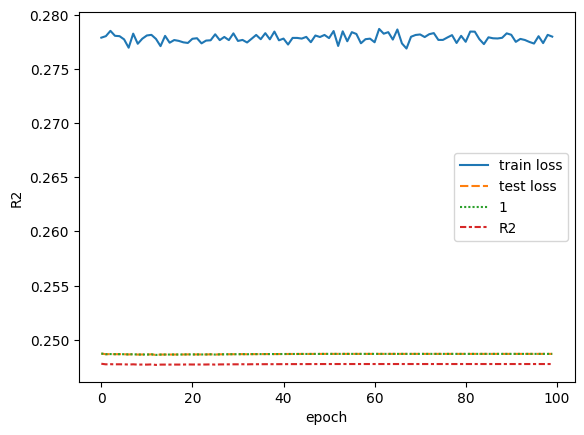

In [90]:
point = pd.DataFrame(np.array(losses), columns=['train loss','test loss',"1", 'R2'])
ax=sns.lineplot(data=point)
ax.set(xlabel='epoch',ylabel='R2')